Імпортуємо необхідні бібліотеки

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Завантажуємо модель Inception V3

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-18 13:18:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.209.48, 142.250.184.112, 142.250.180.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.209.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  7.34MB/s    in 13s     

2023-05-18 13:18:48 (6.66 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Створюємо модель

In [3]:
pre_trained_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),
                                                      include_top=False,
                                                      weights=None)

pre_trained_model.load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in pre_trained_model.layers:
    layer.trainable = False

Metal device set to: Apple M1


Подивимось на архітектуру моделі

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Додаємо до моделі останній шар

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Створюємо модель

In [8]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Компілюємо модель

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Створюємо генератори для тренування та тестування

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator = image_generator.flow_from_directory('dogs',
                                                      target_size=(150,150),
                                                      batch_size=128,
                                                      class_mode='binary',
                                                      subset='training')
test_generator = image_generator.flow_from_directory('dogs',
                                                     target_size=(150,150),
                                                     batch_size=128,
                                                     class_mode='binary',
                                                     subset='validation')

Found 19 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [11]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=2,
                    validation_data=test_generator)

Epoch 1/20


2023-05-18 13:20:36.326892: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 - 3s - loss: 0.7240 - accuracy: 0.5263 - val_loss: 0.1288 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 1s - loss: 8.4748e-04 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 1.0000 - 624ms/epoch - 624ms/step
Epoch 3/20
1/1 - 1s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.2153 - val_accuracy: 1.0000 - 542ms/epoch - 542ms/step
Epoch 4/20
1/1 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1923 - val_accuracy: 1.0000 - 523ms/epoch - 523ms/step
Epoch 5/20
1/1 - 1s - loss: 2.6397e-04 - accuracy: 1.0000 - val_loss: 0.1713 - val_accuracy: 1.0000 - 501ms/epoch - 501ms/step
Epoch 6/20
1/1 - 1s - loss: 7.9196e-05 - accuracy: 1.0000 - val_loss: 0.1613 - val_accuracy: 1.0000 - 506ms/epoch - 506ms/step
Epoch 7/20
1/1 - 1s - loss: 7.8399e-04 - accuracy: 1.0000 - val_loss: 0.1695 - val_accuracy: 1.0000 - 541ms/epoch - 541ms/step
Epoch 8/20
1/1 - 0s - loss: 6.7441e-05 - accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 1.0000 - 486ms/epoch - 486ms/step
Epoch 9/20
1/

In [12]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [13]:
def visualize_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, label='Training')
    plt.plot(epochs, val_acc, label='Validation')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training')
    plt.plot(epochs, val_loss, label='Validation')
    plt.title('Training and validation loss')
    plt.legend()
    plt.grid()
    plt.show()

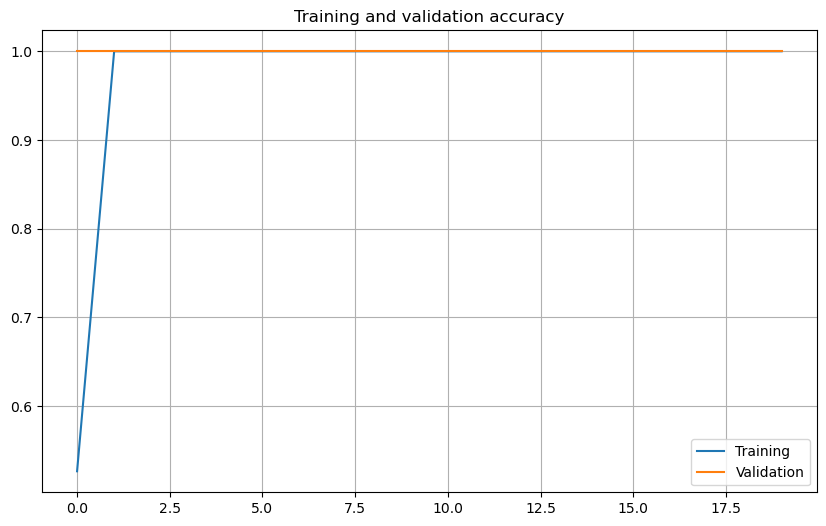

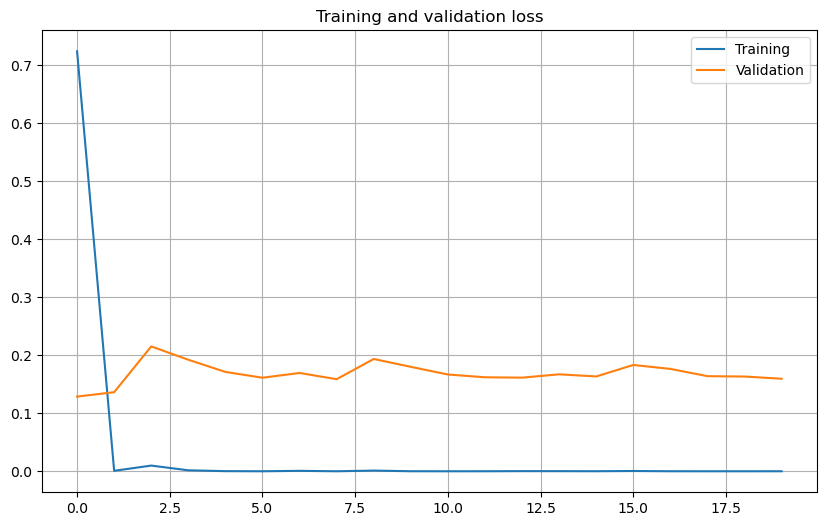

In [14]:
visualize_history(history)

In [15]:
train_batch = next(train_generator)
test_batch = next(test_generator)

1/1 [==============================] - 0s 211ms/step
True: 0.0, predicted: 0.0


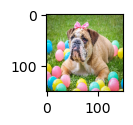

-------------------------------------------------
1/1 [==============================] - 0s 30ms/step
True: 0.0, predicted: 0.0


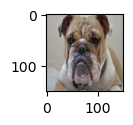

-------------------------------------------------
1/1 [==============================] - 0s 31ms/step
True: 1.0, predicted: 1.0


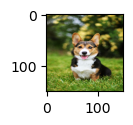

-------------------------------------------------
1/1 [==============================] - 0s 26ms/step
True: 1.0, predicted: 1.0


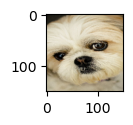

-------------------------------------------------
1/1 [==============================] - 0s 36ms/step
True: 0.0, predicted: 0.0


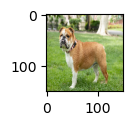

-------------------------------------------------
1/1 [==============================] - 0s 23ms/step
True: 1.0, predicted: 1.0


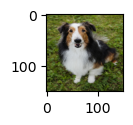

-------------------------------------------------
1/1 [==============================] - 0s 39ms/step
True: 0.0, predicted: 0.0


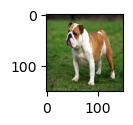

-------------------------------------------------
1/1 [==============================] - 0s 22ms/step
True: 1.0, predicted: 1.0


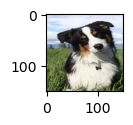

-------------------------------------------------
1/1 [==============================] - 0s 22ms/step
True: 0.0, predicted: 0.0


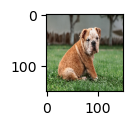

-------------------------------------------------


In [17]:
images = np.concatenate((train_batch[0][:5], test_batch[0][:5]))
labels = np.concatenate((train_batch[1][:5], test_batch[1][:5]))
for img, label in zip(images, labels):
    print(f"True: {label}, predicted: {float(np.round(model.predict(np.expand_dims(img, axis=0))[0][0]))}")
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()
    print("-------------------------------------------------")